<a href="https://colab.research.google.com/github/ClothildeCh/Thesis/blob/main/Results_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Header

Load Gold Test,
T5 wrap reviews,
Load model and tokenizer


In [ ]:
from google.colab import drive
#drive.mount("/content/drive")
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install datasets ftfy

In [ ]:
# Core Libraries
import pandas as pd
import json
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# Transformers
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)


# Datasets
from datasets import Dataset

# Weird Unicode Cleaning
from ftfy import fix_text

# evaluations
from sklearn.metrics import accuracy_score
from difflib import SequenceMatcher

A. Load and Clean Gold Test Set (Aspect-Level)

In [ ]:
# Step 1: Load the aspect-level gold test set
test_gold_df = pd.read_csv("/content/drive/MyDrive/acosqe/evaluation/GOLD_TEST.csv")
test_gold_df.head()

In [ ]:
# Step 2: Clean and normalize fields
test_gold_df["Review Text"] = test_gold_df["Review Text"].astype(str).str.strip()
for col in ["Aspect Term", "Aspect Category", "Opinion Term", "Sentiment Polarity"]:
    test_gold_df[col] = test_gold_df[col].astype(str).str.strip()
test_gold_df["Sentiment Polarity"] = test_gold_df["Sentiment Polarity"].str.lower()
test_gold_df.shape, test_gold_df.head()

In [ ]:
# Step 3: Group quads per review in SSEP format
gold_grouped = defaultdict(list)
for _, row in test_gold_df.iterrows():
    quad = f"{row['Aspect Term']}##{row['Aspect Category']}##{row['Opinion Term']}##{row['Sentiment Polarity']}"
    gold_grouped[row["Review Text"]].append(quad)


In [ ]:
# Step 4: Create a review-level DataFrame with Gold_v4
gold_review_df = pd.DataFrame({
    "Review Text": list(gold_grouped.keys()),
    "Gold_labels": [" [SSEP] ".join(quads) for quads in gold_grouped.values()]
})
gold_review_df.shape, gold_review_df.head()

In [ ]:
# Sanity check
gold_review_df.head()


In [ ]:
!ls -lh /content/drive/MyDrive/acosqe/outputs_v4/

total 20K
drwx------ 2 root root 4.0K Apr  9 21:06 best_model_v4
drwx------ 2 root root 4.0K Apr 12 22:27 checkpoint-1180
drwx------ 2 root root 4.0K Apr 12 22:32 checkpoint-2360
drwx------ 2 root root 4.0K Apr 12 22:34 checkpoint-2655
drwx------ 2 root root 4.0K Apr 12 22:35 checkpoint-2950


In [ ]:
# Reload best model
model = T5ForConditionalGeneration.from_pretrained(
    "/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4/"
).to("cuda")
tokenizer = T5Tokenizer.from_pretrained(
    "/content/drive/MyDrive/acosqe/outputs_v4/best_model_v4/"
)

Step 2: Create Unique Review List for Model Prediction

In [ ]:
unique_reviews = gold_review_df["Review Text"].drop_duplicates().tolist()

def with_prompt(review_text):
    return (
        "Extract all aspect-category-opinion-sentiment quadruples from the following review. "
        "Format each as: aspect##category##opinion##sentiment. Use [SSEP] to separate multiple quads.\n\n"
        + review_text.strip()
    )

test_reviews_prompted = [with_prompt(r) for r in unique_reviews]


In [ ]:
print(test_reviews_prompted)

Step 3: Generate Predictions

In [ ]:
#(Assuming you have already reloaded the model and tokenizer)
# Tokenize and run model
inputs = tokenizer(test_reviews_prompted, return_tensors="pt", padding=True, truncation=True).to(model.device)
outputs = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=256)
decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Create prediction dataframe
pred_df = pd.DataFrame({
    "Review Text": unique_reviews,
    "Prediction_v4": decoded_preds
})

In [ ]:
pred_df.head()

In [ ]:
# Save predictions if needed
pred_df[["Review Text", "Prediction_v4"]].to_csv(
    "/content/drive/MyDrive/acosqe/eval_outputs/predictions_big_gold_v4.csv", index=False
)

Step 4: Merge Predictions Back to Gold

In [ ]:
# pred_df: DataFrame with columns ["Review Text", "Prediction_v4"]
eval_df = gold_review_df.merge(pred_df, on="Review Text", how="left")

In [ ]:
eval_df.head()

# 1. Exact Match Accuracy

In [ ]:
# Clean up: strip leading/trailing whitespace for safe comparison
eval_df["Gold_labels"] = eval_df["Gold_labels"].astype(str).str.strip()
eval_df["Prediction_v4"] = eval_df["Prediction_v4"].astype(str).str.strip()

# Compute binary exact match per row
eval_df["Exact_Match"] = eval_df["Gold_labels"] == eval_df["Prediction_v4"]

# Compute overall accuracy
exact_match_accuracy = eval_df["Exact_Match"].mean()

# Print result
print(f"Exact Match Accuracy: {exact_match_accuracy * 100:.2f}%")

Exact Match Accuracy: 2.26%


# 2. Per-Quad F1 Score

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Parse quads from string format
def parse_quads(s):
    if pd.isna(s) or not s.strip():
        return set()
    return set(q.strip() for q in s.split("[SSEP]"))

# Extract sets
eval_df["Gold_set"] = eval_df["Gold_labels"].apply(parse_quads)
eval_df["Pred_set"] = eval_df["Prediction_v4"].apply(parse_quads)

# Flatten to list of gold and predicted quads
all_gold = set()
all_pred = set()
for _, row in eval_df.iterrows():
    all_gold.update(row["Gold_set"])
    all_pred.update(row["Pred_set"])

# Compute TP, FP, FN
tp = len(all_gold & all_pred)
fp = len(all_pred - all_gold)
fn = len(all_gold - all_pred)

# Precision, Recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"Per-Quad Precision: {precision:.3f}")
print(f"Per-Quad Recall:    {recall:.3f}")
print(f"Per-Quad F1 Score:  {f1:.3f}")


Per-Quad Precision: 0.078
Per-Quad Recall:    0.102
Per-Quad F1 Score:  0.089


# 3. Category Confusion Matrix

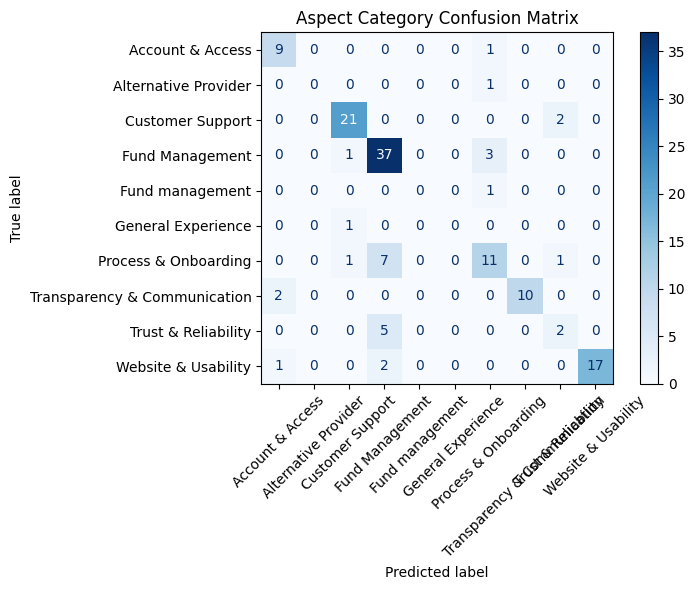

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Reuse your parsing function from earlier
def parse_quads(s):
    if pd.isna(s) or not s.strip():
        return []
    return [q.strip() for q in s.split("[SSEP]")]

# Build long-form DataFrame from prediction column
records = []

for _, row in eval_df.iterrows():
    review = row["Review Text"]
    gold_quads = parse_quads(row["Gold_labels"])
    pred_quads = parse_quads(row["Prediction_v4"])

    gold_terms_to_cat = {
        q.split("##")[0].strip(): q.split("##")[1].strip()
        for q in gold_quads
    }

    for q in pred_quads:
        try:
            aspect, pred_cat, _, _ = [x.strip() for x in q.split("##")]
        except ValueError:
            continue  # skip malformed
        gold_cat = gold_terms_to_cat.get(aspect, "None")  # gold category or None
        records.append((gold_cat, pred_cat))

# Create DataFrame
cf_df = pd.DataFrame(records, columns=["Gold Category", "Predicted Category"])

# Filter to known categories
categories = sorted(set(cf_df["Gold Category"]) | set(cf_df["Predicted Category"]))
categories = [c for c in categories if c != "None"]

# Build confusion matrix
cm = confusion_matrix(cf_df["Gold Category"], cf_df["Predicted Category"], labels=categories)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Aspect Category Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Export confusion matrix as DataFrame
cm_df = pd.DataFrame(cm, index=categories, columns=categories)
cm_df.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/category_confusion_matrix_v4_fix.csv")

# 4. Component-Level Accuracy

In [ ]:
def parse_quads(s):
    if pd.isna(s) or not s.strip():
        return []
    return [q.strip() for q in s.split("[SSEP]") if "##" in q]

# Initialize lists
component_hits = {"aspect": 0, "category": 0, "opinion": 0, "sentiment": 0}
component_total = 0

# For each review
for _, row in eval_df.iterrows():
    gold_quads = parse_quads(row["Gold_labels"])
    pred_quads = parse_quads(row["Prediction_v4"])

    # Convert gold to component tuples
    gold_components = [tuple(g.split("##")) for g in gold_quads]

    for pred in pred_quads:
        try:
            aspect_p, cat_p, opin_p, sent_p = [x.strip() for x in pred.split("##")]
        except ValueError:
            continue  # skip malformed prediction

        best_match = None
        best_score = 0

        # Find best matching gold quad (by aspect + opinion overlap)
        for gold in gold_components:
            aspect_g, cat_g, opin_g, sent_g = gold
            match_score = int(aspect_p == aspect_g) + int(opin_p == opin_g)  # simple heuristic
            if match_score > best_score:
                best_score = match_score
                best_match = gold

        if best_match:
            aspect_g, cat_g, opin_g, sent_g = best_match
            component_hits["aspect"] += int(aspect_p == aspect_g)
            component_hits["category"] += int(cat_p == cat_g)
            component_hits["opinion"] += int(opin_p == opin_g)
            component_hits["sentiment"] += int(sent_p == sent_g)
            component_total += 1

# Compute accuracy per component
for comp, hits in component_hits.items():
    acc = hits / component_total if component_total > 0 else 0
    print(f"{comp.capitalize()} Accuracy: {acc:.3f}")

Aspect Accuracy: 0.761
Category Accuracy: 0.750
Opinion Accuracy: 0.523
Sentiment Accuracy: 0.983


# 5. Error Type Tagging

- What: Manual or semi-automated classification into: undergeneration, hallucination, wrong sentiment, etc.

- Why: Adds a rich qualitative layer for analysis.

In [ ]:
from collections import defaultdict
import pandas as pd

error_records = []

def parse_quad_components(quad_str):
    try:
        a, c, o, s = [x.strip() for x in quad_str.split("##")]
        return a, c, o, s
    except ValueError:
        return None

# Loop over each review
for _, row in eval_df.iterrows():
    gold_quads = parse_quads(row["Gold_labels"])
    pred_quads = parse_quads(row["Prediction_v4"])

    gold_set = set(gold_quads)
    pred_set = set(pred_quads)

    gold_components = [parse_quad_components(q) for q in gold_quads]
    pred_components = [parse_quad_components(q) for q in pred_quads]

    matched_gold = set()
    matched_pred = set()

    # First, check for exact matches
    for i, pred in enumerate(pred_components):
        if pred is None:
            continue
        if "##".join(pred) in gold_set:
            error_records.append({"Review Text": row["Review Text"], "Prediction": "##".join(pred), "Error Type": "Correct"})
            matched_gold.add("##".join(pred))
            matched_pred.add(i)

    # Now handle errors
    for i, pred in enumerate(pred_components):
        if i in matched_pred or pred is None:
            continue
        best_type = "Hallucination"
        for g in gold_components:
            if g is None:
                continue
            aspect_match = pred[0] == g[0]
            category_match = pred[1] == g[1]
            opinion_match = pred[2] == g[2]
            sentiment_match = pred[3] == g[3]
            match_score = aspect_match + category_match + opinion_match + sentiment_match
            if match_score == 3:
                if not sentiment_match:
                    best_type = "Wrong Sentiment"
                elif not category_match:
                    best_type = "Wrong Category"
                elif not (aspect_match and opinion_match):
                    best_type = "Wrong Aspect/Opinion"
                break
        error_records.append({
            "Review Text": row["Review Text"],
            "Prediction": "##".join(pred),
            "Error Type": best_type
        })

    # Handle missing gold quads (Undergeneration)
    for g in gold_set:
        if g not in matched_gold:
            error_records.append({
                "Review Text": row["Review Text"],
                "Prediction": g,
                "Error Type": "Undergeneration"
            })

In [ ]:
error_df = pd.DataFrame(error_records)
summary = error_df["Error Type"].value_counts()
print(summary)

Error Type
Hallucination           352
Undergeneration         326
Wrong Aspect/Opinion     95
Correct                  37
Wrong Category           12
Name: count, dtype: int64


In [ ]:
error_df.to_csv("/content/drive/MyDrive/acosqe/eval_outputs/Error_Type_Tagging_v4_fix.csv", index=False)

# 6. Partial Match Rate:

In [ ]:
from collections import defaultdict

partial_match_records = []

for _, row in eval_df.iterrows():
    gold_quads = parse_quads(row["Gold_labels"])
    pred_quads = parse_quads(row["Prediction_v4"])

    gold_components = [parse_quad_components(q) for q in gold_quads]
    pred_components = [parse_quad_components(q) for q in pred_quads]

    for pred in pred_components:
        if pred is None:
            continue
        best_score = 0
        for gold in gold_components:
            if gold is None:
                continue
            score = sum([p == g for p, g in zip(pred, gold)])
            if score > best_score:
                best_score = score
        partial_match_records.append(best_score)

# Count match distribution
from collections import Counter
match_counts = Counter(partial_match_records)
total_preds = len(partial_match_records)

# Print partial match rate summary
print("Partial Match Rate Breakdown (per predicted quad):")
for k in range(5):  # 0 to 4
    count = match_counts.get(k, 0)
    percent = count / total_preds * 100 if total_preds > 0 else 0
    print(f"{k}/4 match: {count} ({percent:.2f}%)")

Partial Match Rate Breakdown (per predicted quad):
0/4 match: 4 (0.81%)
1/4 match: 136 (27.42%)
2/4 match: 212 (42.74%)
3/4 match: 107 (21.57%)
4/4 match: 37 (7.46%)


Gold-Centric Partial Match

In [ ]:
from collections import Counter

def parse_quads(s):
    if pd.isna(s) or not s.strip():
        return []
    return [q.strip() for q in s.split("[SSEP]") if "##" in q]

def parse_quad_components(quad_str):
    try:
        a, c, o, s = [x.strip() for x in quad_str.split("##")]
        return a, c, o, s
    except ValueError:
        return None

gold_partial_scores = []

for _, row in eval_df.iterrows():
    gold_quads = parse_quads(row["Gold_labels"])
    pred_quads = parse_quads(row["Prediction_v4"])

    pred_components = [parse_quad_components(q) for q in pred_quads]
    gold_components = [parse_quad_components(q) for q in gold_quads]

    for gold in gold_components:
        if gold is None:
            continue
        best_score = 0
        for pred in pred_components:
            if pred is None:
                continue
            score = sum([g == p for g, p in zip(gold, pred)])
            if score > best_score:
                best_score = score
        gold_partial_scores.append(best_score)

# Count match distribution
from collections import Counter
gold_match_counts = Counter(gold_partial_scores)
total_gold = len(gold_partial_scores)

# Print results
print("Gold-Centric Partial Match Rate:")
for k in range(5):
    count = gold_match_counts.get(k, 0)
    percent = count / total_gold * 100 if total_gold > 0 else 0
    print(f"{k}/4 match: {count} ({percent:.2f}%)")


Gold-Centric Partial Match Rate:
0/4 match: 5 (1.38%)
1/4 match: 91 (25.07%)
2/4 match: 138 (38.02%)
3/4 match: 92 (25.34%)
4/4 match: 37 (10.19%)


| Metric              | v4 (leaked) | v4.1 (fair) |
|---------------------|-------------|-------------|
| Exact Match         | 0.0395      | 0.0226      |
| Per-Quad Precision  | 0.104       | 0.078       |
| Per-Quad Recall     | 0.139       | 0.102       |
| Per-Quad F1         | 0.119       | 0.089       |
| Aspect Accuracy     | 0.768       | 0.761       |
| Category Accuracy   | 0.742       | 0.750       |
| Opinion Accuracy    | 0.511       | 0.523       |
| Sentiment Accuracy  | 0.957       | 0.983       |


Model v4.1 was selected for final annotation of the Trustpilot corpus, as it demonstrated superior precision, recall, F1, and component accuracy under fair evaluation conditions. Unlike v5, which incorporated human-validated machine inferences, v4.1 was trained solely on manually annotated data, ensuring higher generalisation and interpretability. Its outputs were subsequently used to enrich the full dataset for Power BI visualisation.

In [ ]:
df.head()

In [ ]:
print(raw_df.columns.tolist())


['ï»¿Review Text', 'Aspect Term', 'Aspect Category', 'Opinion Term', 'Sentiment Polarity', 'Done', 'Main', 'Human']


In [ ]:

# 1. Load Full Dataset


# Load your cleaned, annotated dataset
raw_df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/Quad_Annotation_v5.csv", encoding="ISO-8859-1")
raw_df.rename(columns={raw_df.columns[0]: "Review Text"}, inplace=True)
# Filter to keep only unannotated reviews
raw_df = raw_df[~raw_df["Done"].isin(["Y"])]
raw_df = raw_df["Review Text"].dropna().drop_duplicates().astype(str).str.strip().reset_index(drop=True)

# Create review-level DataFrame
gold_review_df = pd.DataFrame({"Review Text": raw_df})

gold_review_df.head()

In [ ]:
from tqdm import tqdm
import torch

In [ ]:
#
# 2. Run v4.1 Predictions
#
# Chunked inference with batching
BATCH_SIZE = 32
predictions = []

for i in tqdm(range(0, len(gold_review_df), BATCH_SIZE)):
    batch = gold_review_df.iloc[i:i + BATCH_SIZE]
    inputs = tokenizer(
        batch["Prompted Review"].tolist(),
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=256
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(decoded)

# 3.Save predictions to DataFrame
gold_review_df["Predicted_Quads"] = predictions
gold_review_df.head()

100%|██████████| 257/257 [09:09<00:00,  2.14s/it]


,Review Text,Prompted Review,Predicted_Quads
0,"Whas great, but take some time, to do that!",Extract all aspect-category-opinion-sentiment ...,nan##Process & Onboarding##great##positive [SS...
1,Very easy to do and the money was transferred ...,Extract all aspect-category-opinion-sentiment ...,transfer##Fund Management##easy##positive [SSE...
2,"Pot transfer was a huge pain, caused by a very...",Extract all aspect-category-opinion-sentiment ...,customer service##Customer Support##terrible##...
3,Impossible to use. Constantly locks you out. A...,Extract all aspect-category-opinion-sentiment ...,use##Website & Usability##impossible##negative...
4,I would cancel that payment,Extract all aspect-category-opinion-sentiment ...,payment##Fund Management##cancell##negative


In [ ]:
gold_review_df.drop(columns=['Prompted Review'], inplace=True)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} GB of available RAM")

Your runtime has 13.6 GB of available RAM


Add a Review ID in Python (before exporting) !!!

In [ ]:
# Load your review-level prediction dataframe
df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/Quad_Annotation_v5.csv", encoding="ISO-8859-1")
df.rename(columns={df.columns[0]: "Review Text"}, inplace=True)
# Drop rows where predictions are missing
df = df[df["Done"].isin(["Y","AUTO"])]
df.head()

In [ ]:
# Split on [SSEP] into separate ACOS strings
gold_review_df["Predicted_Quads"] = predictions
gold_review_df.head()

,Review Text,Predicted_Quads
0,"Whas great, but take some time, to do that!",nan##Process & Onboarding##great##positive [SS...
1,Very easy to do and the money was transferred ...,transfer##Fund Management##easy##positive [SSE...
2,"Pot transfer was a huge pain, caused by a very...",customer service##Customer Support##terrible##...
3,Impossible to use. Constantly locks you out. A...,use##Website & Usability##impossible##negative...
4,I would cancel that payment,payment##Fund Management##cancell##negative


In [ ]:
#   Helper functions from your partial match code
def parse_quads(s):
    if pd.isna(s) or not s.strip():
        return []
    return [q.strip() for q in s.split("[SSEP]") if "##" in q]

def parse_quad_components(quad_str):
    try:
        a, c, o, s = [x.strip() for x in quad_str.split("##")]
        return a, c, o, s
    except ValueError:
        return None

#   Parse all predictions into rows
records = []

for idx, row in gold_review_df.iterrows():
    review_text = row["Review Text"]
    quad_strings = parse_quads(row["Predicted_Quads"])

    for quad in quad_strings:
        components = parse_quad_components(quad)
        if components is None:
            continue  # skip malformed
        a, c, o, s = components
        records.append({
            "Review ID": idx + 1,
            "Review Text": review_text,
            "Aspect Term": a,
            "Aspect Category": c,
            "Opinion Term": o,
            "Sentiment Polarity": s,
            "Source": "Model"
        })


In [ ]:
# Convert to DataFrame
df_aspect_level = pd.DataFrame(records)
df_aspect_level.head()

add date and time

In [ ]:
scraped_df = pd.read_csv("/content/drive/MyDrive/acosqe/raw_data/trustpilot_reviews_combined.csv")

# Re Preprocessing
# Normalize text to help match reviews
df_aspect_level['Review Text'] = df_aspect_level['Review Text'].str.strip().str.lower()
scraped_df['Review Text'] = scraped_df['Review Text'].str.strip().str.lower()


In [ ]:
scraped_df.head()

In [ ]:
# Then Merge on Review Text (Left Join otherwise messy)
merged_df = pd.merge(df_aspect_level, scraped_df, on='Review Text', how='left')

# Finally Inspect Missing Metadata
missing = merged_df[merged_df['Rating'].isnull()]
print(f"Reviews missing star rating after merge: {len(missing)}")
merged_df.head()


In [ ]:
# Save to file
merged_df.to_csv("/content/drive/MyDrive/acosqe/raw_data/PowerBI.csv", index=False)